In [1]:
import sys
import pandas as pd
from pathlib import Path

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

In [2]:
import src.loadProcessed as loadp

counts = loadp.load_processed_count()
locations = loadp.load_processed_locations()

# Initial Exploration

In [3]:
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.dates

Text(0, 0.5, 'Count')

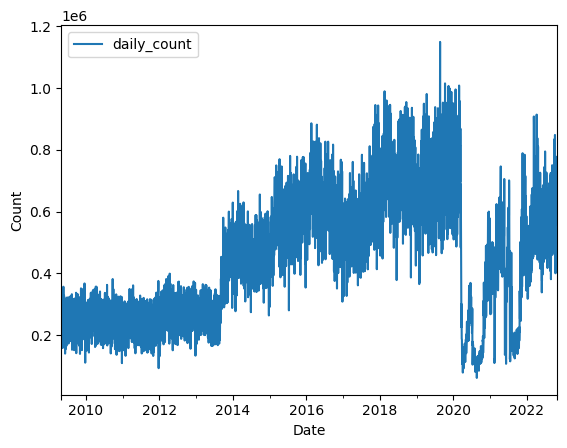

In [4]:
counts_by_sensor: pd.DataFrame = counts.groupby(counts['sensing_date'])['daily_count'].sum().reset_index()

ax: matplotlib.axes.Axes = counts_by_sensor.plot.line(
    x='sensing_date', y='daily_count',
)
ax.set_xlabel("Date")
ax.set_ylabel("Count")

I wanted to visualise how the number of counts changes over time. 
As we can see in the above plot, there is a general trend upwards. There are a few reasons for this I will need to explore. First of these is that more sensors are installed over time so we need to account for that, this will most likely involve treating sensors as categorical variables. Secondly, since I am most interested in the behaviour of the population, rather than the congestion of the city, I would like to account for the population size of melbourne as well as that has increased significantly over time.

In [5]:
counts_by_sensor: pd.DataFrame = (
    counts.groupby(
        ['sensor_id', 'sensing_date'], observed=False
    )['daily_count']                                                   # ['daily_count'] makes it a series with the multiindex as the index
    .sum()                                                             # So the sum just sums over the values (aggregates hourly_count per sensor x time combo)
    .unstack(level='sensor_id')                                        # Seperates out the multiindex to treat each sensor as a level, date makes up the new index
)


To make the initial analysis a bit easier, I'm going to focus on a single key sensor. Later in the process I'll reintroduce other sensors so that I can improve the power of my tests

Text(0.5, 1.0, 'Grattan St-Swanston St (West) Count highlighting 1 3')

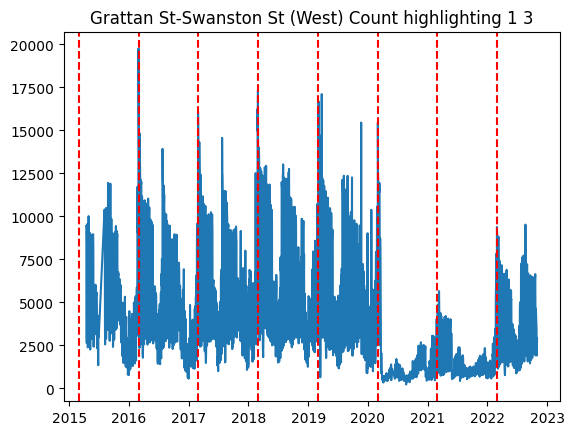

In [6]:
single_sensor_loc = locations[locations['sensor_name'] == 'UM1_T']

single_sensor_counts = pd.DataFrame.merge(
    single_sensor_loc, counts, how='inner', on='sensor_id'
)

fig, ax = plt.subplots()
ax.plot(single_sensor_counts['sensing_date'], single_sensor_counts['daily_count'], label='Daily Counts')

highlight_day, highlight_month = 1, 3 
for year in range(
    single_sensor_counts['sensing_date'].min().year,
    single_sensor_counts['sensing_date'].max().year + 1
):
    nye = pd.Timestamp(year=year, month=highlight_month, day=highlight_day)
    x_coord = float(matplotlib.dates.date2num(nye))

    ax.axvline(x_coord, color='red', linestyle='--')

ax.set_title(f'{single_sensor_loc['sensor_description'].item()} Count highlighting {highlight_day} {highlight_month}')


I found that many sensor locations have a specific pattern of activity that aligns with events in that location. Pictured is near The University of Melbourne where we can see a clear correlation with the university semesters. We can see that there is a sharp peak at the start of semester, which slowly decreases as it gets later in semester. 

In other locations I saw other such yearly patters such as for the Australian Open finals, new years eve, or pre-christmas shopping.

I believe that many of these location specific variations will be ironed out later such that we can see the effect of covid on foot traffic.
We can see that the foot traffic was much lower during lockdowns in 2020 and 2021 and then does not quite recover afterwards, which is supporting my theory. However with the specific example above, this may be due to a change in university policy to allow for more online learning.